# generate_alongshore_currents

Given a coastline and the vector field of interest, generate the alongshore currents along the given coastline

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io
import scipy.spatial
from shapely.geometry import LineString, Point, box
from shapely.ops import nearest_points

from pyplume.constants import DATA_DIR, FIELD_NETCDF_DIR
import pyplume.utils as utils
from pyplume.dataloaders import dataset_to_fieldset, SurfaceGrid
from pyplume.thredds_data import rename_dataset_vars

In [3]:
velocity_field_nc = FIELD_NETCDF_DIR / "tj_plume_1km_2022-09.nc"
coastline_mat = DATA_DIR / "socal_boundary.mat"
output_file = "data/field_netcdfs/tj_plume_alongshore_2022-09.nc"
# velocity_field_nc = FIELD_NETCDF_DIR / "tj_plume_1km_2020-03.nc"
# coastline_mat = DATA_DIR / "coastline.mat"
# output_file = "data/field_netcdfs/tijuana_alongshore.nc"
# 1 km resolution values
lat_diff = 0.00898933
lon_diff = 0.01042175

In [4]:
vel_ds = rename_dataset_vars(xr.open_dataset(velocity_field_nc))
lats, lons = utils.load_pts_mat(coastline_mat)
coastline = LineString(np.array([lats, lons]).T)

In [5]:
if lat_diff is None:
    lat_diff = abs(np.diff(lats).min())
if lon_diff is None:
    lon_diff = abs(np.diff(lons).min())

In [6]:
lat_start = min(lats.min(), vel_ds["lat"].values.min())
lat_end = max(lats.max(), vel_ds["lat"].values.max())
lon_start = min(lons.min(), vel_ds["lon"].values.min())
lon_end = max(lons.max(), vel_ds["lon"].values.max())

In [7]:
lat_steps = math.ceil((lat_end - lat_start) / lat_diff) + 1
lon_steps = math.ceil((lon_end - lon_start) / lon_diff) + 1

In [8]:
lats_grid = lat_start + np.arange(lat_steps) * lat_diff
lons_grid = lon_start + np.arange(lon_steps) * lon_diff

In [9]:
grid = np.empty((len(lats_grid), len(lons_grid)), dtype=object)
info = np.empty((len(lats_grid), len(lons_grid)), dtype=object)

In [10]:
# I tried to do something like ray tracing, realized I couldn't be bothered to think about it
# here, have this brute force approach instead
# lol
# I assume the coordinates use an Arakawa A-grid
for i in range(len(lats_grid)):
    for j in range(len(lons_grid)):
        latmin = lats_grid[i] - lat_diff / 2
        latmax = lats_grid[i] + lat_diff / 2
        lonmin = lons_grid[j] - lon_diff / 2
        lonmax = lons_grid[j] + lon_diff / 2
        grid[i, j] = box(latmin, lonmin, latmax, lonmax)

In [11]:
import math
for i in range(len(lats) - 1):
    segment = LineString([[lats[i], lons[i]], [lats[i + 1], lons[i + 1]]])
    vec = (lons[i + 1] - lons[i], lats[i + 1] - lats[i])
    start_j = int((lats[i] - lats_grid[0]) // lat_diff)
    end_j = math.ceil((lats[i + 1] - lats_grid[0]) / lat_diff)
    start_k = int((lons[i] - lons_grid[0]) // lon_diff)
    end_k = math.ceil((lons[i + 1] - lons_grid[0]) / lon_diff)
    for j in range(min(start_j, end_j), max(start_j, end_j) + 1):
        for k in range(min(start_k, end_k), max(start_k, end_k) + 1):
            if info[j, k] is None and segment.intersects(grid[j, k]):
                info[j, k] = vec

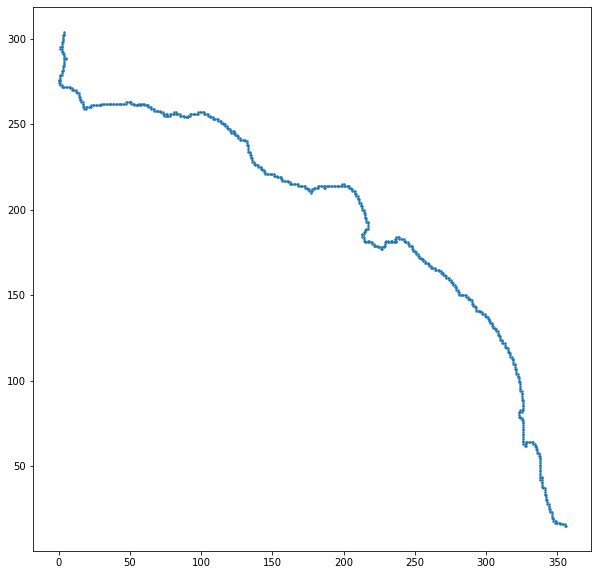

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(np.where(info != None)[1], np.where(info != None)[0], s=2)

### The vectors at each coastline grid point tangental to the coastline

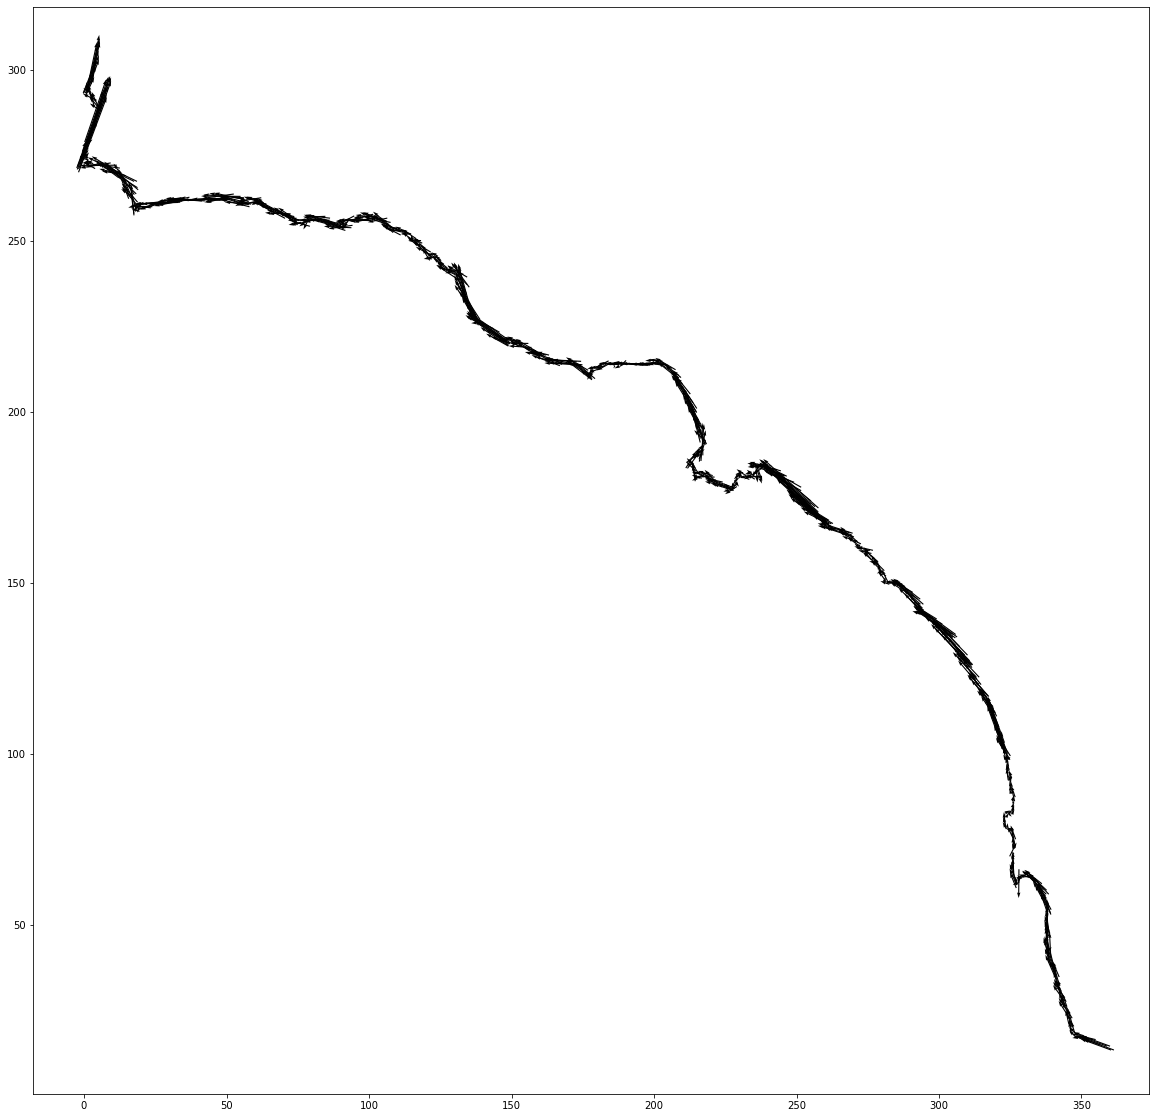

In [13]:
plt.figure(figsize=(20, 20))
info_where = np.where(info != None)
plt.quiver(
    info_where[1],
    info_where[0],
    list(map(lambda x: x[0], info[info_where])),
    list(map(lambda x: x[1], info[info_where])),
    width=0.001,
    pivot='mid'
)

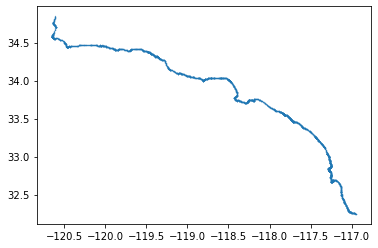

In [14]:
plt.scatter(lons, lats, s=0.1)

In [15]:
coast_u = np.tile((np.full(grid.shape, np.nan)), (len(vel_ds["time"]), 1, 1))
coast_v = np.tile((np.full(grid.shape, np.nan)), (len(vel_ds["time"]), 1, 1))
mgrid = np.meshgrid(vel_ds["lat"], vel_ds["lon"], indexing="ij")

In [16]:
# this is gonna take a while to run
for i in range(len(vel_ds["time"])):
    nonzero = np.where(~np.isnan(vel_ds["U"])[i])
    if len(nonzero[0]) == 0:
        continue
    positions = np.array([mgrid[0][nonzero], mgrid[1][nonzero]]).T
    kdtree = scipy.spatial.KDTree(positions)
    u = vel_ds["U"][i].values
    v = vel_ds["V"][i].values
    for j in range(grid.shape[0]):
        for k in range(grid.shape[1]):
            if info[j, k] is not None:
                closest_idx = kdtree.query([lats_grid[j], lons_grid[k]])[1]
                closest_u = u[nonzero[0][closest_idx], nonzero[1][closest_idx]]
                closest_v = v[nonzero[0][closest_idx], nonzero[1][closest_idx]]
                vec = info[j, k]  # this order should be in u, v (it was diff lon, diff lat)
                # project u, v pair onto coastline vector
                scalar = (closest_u * vec[0] + closest_v * vec[1]) / (vec[0] ** 2 + vec[1] ** 2)
                coast_u[i, j, k] = scalar * vec[0]
                coast_v[i, j, k] = scalar * vec[1]

### The alongshore current calculated along each coast grid point

This is for a single timestamp

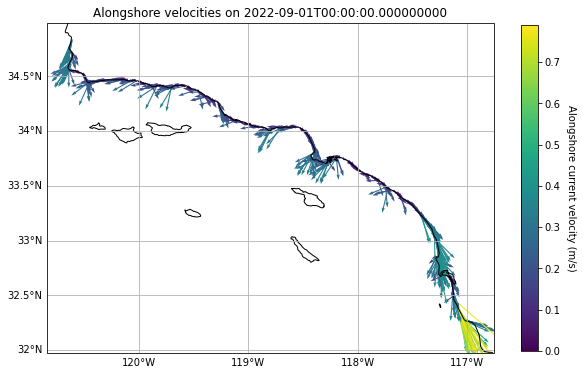

In [17]:
from pyplume.plotting import get_carree_axis, get_carree_gl
import cartopy
import cartopy.crs as ccrs

idx = 0
tstamp = vel_ds["time"][0].values
othermgrid = np.meshgrid(lats_grid, lons_grid, indexing="ij")
us = coast_u[idx].flatten()
vs = coast_v[idx].flatten()
mags = np.sqrt(us ** 2 + vs ** 2)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.COASTLINE)
quiv = ax.quiver(
    othermgrid[1].flatten(),
    othermgrid[0].flatten(),
    us,
    vs,
    mags,
    scale=6
)
get_carree_gl(ax)
cbar = fig.colorbar(quiv, shrink=0.6)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Alongshore current velocity (m/s)", rotation=270)
ax.set_title(f"Alongshore velocities on {tstamp}")
fig.show()

In [18]:
ds = xr.Dataset(
    data_vars={
        "U": (["time", "lat", "lon"], coast_u),
        "V": (["time", "lat", "lon"], coast_v)
    },
    coords={
        "time": vel_ds["time"],
        "lat": lats_grid,
        "lon": lons_grid
    }
)

In [19]:
from parcels import Field, VectorField
from parcels.tools.converters import GeographicPolar, Geographic
from pyplume.dataloaders import dataset_to_fieldset

fu = Field.from_xarray(ds["U"], "CU", dict(lat="lat", lon="lon", time="time"), interp_method="nearest")
fu.units = GeographicPolar()
fv = Field.from_xarray(ds["V"], "CV", dict(lat="lat", lon="lon", time="time"), interp_method="nearest")
fv.units = Geographic()
fuv = VectorField("CUV", fu, fv)

In [20]:
ds.to_netcdf(output_file)